# The scientific challenge of the 6th International Conference on Biomedical and Health Informatics (ICBHI2024)

In [1]:
# imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization, LSTM
from scipy.interpolate import CubicSpline
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from google.colab import drive

In [2]:
# set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
set_seed(42)

In [3]:
# mount google drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ICBHI2024')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# data augmentation methods
def add_noise(data, noise_factor=0.2):
    noise = np.random.randn(*data.shape) * noise_factor
    return data + noise

def scale_data(data, scale_factor=0.2):
    return data * scale_factor

def time_warp(data, sigma=0.2):
    from scipy.interpolate import CubicSpline
    if len(data.shape) != 2:
        raise ValueError("Data shape is not compatible for time warping.")
    orig_steps = np.arange(data.shape[1])
    random_warp = np.random.normal(loc=1.0, scale=sigma, size=data.shape[1])
    warp_steps = np.cumsum(random_warp) / np.sum(random_warp) * (data.shape[1] - 1)
    warped_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        cs = CubicSpline(orig_steps, data[i, :])
        warped_data[i, :] = cs(warp_steps)
    return warped_data

def jitter(data, sigma=0.05):
    return data + np.random.normal(loc=0.0, scale=sigma, size=data.shape)

# function to clean data
def clean_data(data):
    if not np.all(np.isfinite(data)):
        if data.ndim == 1:
            mean_val = np.nanmean(data)
            data = np.where(np.isfinite(data), data, mean_val)
        elif data.ndim == 2:
            mean_vals = np.nanmean(data, axis=1, keepdims=True)
            data = np.where(np.isfinite(data), data, mean_vals)
    return data

# function to augment data
def augment_data(data, labels):
    augmented_data = []
    augmented_labels = []
    for sample, label in zip(data, labels):
        sample = clean_data(sample)  # clean data before augmentation

        augmented_data.append(sample)
        augmented_labels.append(label)

        augmented_data.append(add_noise(sample))
        augmented_labels.append(label)

        augmented_data.append(scale_data(sample))
        augmented_labels.append(label)

        augmented_data.append(time_warp(sample[np.newaxis, ...]).squeeze(0))
        augmented_labels.append(label)

        augmented_data.append(jitter(sample))
        augmented_labels.append(label)

    return np.array(augmented_data), np.array(augmented_labels)

# function to load data from npz files
def load_npz_data(fpath):
    all_data = np.load(fpath)
    return all_data['data']

# function to load participant data
def load_participants_data(data_dir, augment_data_flag=False, labels_present=True):
    subjects = sorted([s for s in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, s))])
    all_resp_data = []
    all_labels = []
    subject_names = []

    print(f"Loading data from {data_dir}...")
    for subject in subjects:
        if subject.startswith('.'):
            continue  # skip hidden files like .DS_Store

        subject_path = os.path.join(data_dir, subject)
        resp_data_path = os.path.join(subject_path, 'Resp_data.npz')

        if os.path.exists(resp_data_path):
            resp_data = load_npz_data(resp_data_path)
            print(f"Subject {subject} Resp data shape: {resp_data.shape}")
            resp_data = resp_data[:, 2000:8000]
            all_resp_data.append(resp_data)
        else:
            print(f"Missing data for {subject}")

        if labels_present:
            labels_path = os.path.join(subject_path, 'labels.npz')
            if os.path.exists(labels_path):
                labels = load_npz_data(labels_path)[:, 1].astype(int)  # only take the level label
                print(f"Subject {subject} labels shape: {labels.shape}")
                all_labels.append(labels)
            else:
                print(f"Missing labels for {subject}")

        # track the subject names
        subject_names.append(subject)

    # combine all data and labels from all subjects
    all_resp_data = np.concatenate(all_resp_data, axis=0)
    print(f"All Resp data shape after concatenation: {all_resp_data.shape}")
    all_labels = np.concatenate(all_labels, axis=0) if labels_present and all_labels else None
    if all_labels is not None:
        print(f"All labels shape after concatenation: {all_labels.shape}")

    if augment_data_flag and all_labels is not None:
        all_resp_data, all_labels = augment_data(all_resp_data, all_labels)
        print(f"Augmented Resp data shape: {all_resp_data.shape}")
        print(f"Augmented labels shape: {all_labels.shape}")

    if labels_present and all_labels is not None:
        return {'resp_data': all_resp_data, 'labels': all_labels, 'subject_names': subject_names}
    else:
        return {'resp_data': all_resp_data, 'subject_names': subject_names}

# load data
train_data_dir = 'data/Train'
test_data_dir = 'data/Test'

train_data = load_participants_data(train_data_dir, augment_data_flag=True, labels_present=True)
test_data = load_participants_data(test_data_dir, augment_data_flag=False, labels_present=False)

print(f"Train data keys: {train_data.keys()}")
print(f"Test data keys: {test_data.keys()}")
print(f"Train Resp data shape: {train_data['resp_data'].shape}")
print(f"Train labels shape: {train_data['labels'].shape}")
print(f"Test Resp data shape: {test_data['resp_data'].shape}")

Loading data from data/Train...
Subject P01 Resp data shape: (30, 10000)
Subject P01 labels shape: (30,)
Subject P02 Resp data shape: (30, 10000)
Subject P02 labels shape: (30,)
Subject P03 Resp data shape: (30, 10000)
Subject P03 labels shape: (30,)
Subject P04 Resp data shape: (30, 10000)
Subject P04 labels shape: (30,)
Subject P05 Resp data shape: (30, 10000)
Subject P05 labels shape: (30,)
Subject P06 Resp data shape: (30, 10000)
Subject P06 labels shape: (30,)
Subject P07 Resp data shape: (30, 10000)
Subject P07 labels shape: (30,)
Subject P08 Resp data shape: (30, 10000)
Subject P08 labels shape: (30,)
Subject P09 Resp data shape: (30, 10000)
Subject P09 labels shape: (30,)
Subject P10 Resp data shape: (30, 10000)
Subject P10 labels shape: (30,)
Subject P11 Resp data shape: (30, 10000)
Subject P11 labels shape: (30,)
Subject P12 Resp data shape: (30, 10000)
Subject P12 labels shape: (30,)
Subject P13 Resp data shape: (30, 10000)
Subject P13 labels shape: (30,)
Subject P14 Resp da

Training on fold 1...
Epoch 1/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.2633 - loss: 2.1146 - val_accuracy: 0.2550 - val_loss: 2.1597 - learning_rate: 5.0000e-04
Epoch 2/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2622 - loss: 2.0867 - val_accuracy: 0.2517 - val_loss: 2.1251 - learning_rate: 5.0000e-04
Epoch 3/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2631 - loss: 2.0785 - val_accuracy: 0.2567 - val_loss: 2.1083 - learning_rate: 5.0000e-04
Epoch 4/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2657 - loss: 2.0799 - val_accuracy: 0.2483 - val_loss: 2.1012 - learning_rate: 5.0000e-04
Epoch 5/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2698 - loss: 2.0748 - val_accuracy: 0.2350 - val_loss: 2.1028 - learning_rate: 5.0000e-04
Epoch 6/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2713 - loss: 2.0703 - val_accuracy: 0.2417 - val_loss: 2.1036 - learning_rate: 5.0000e-04
Epoch 7/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/st

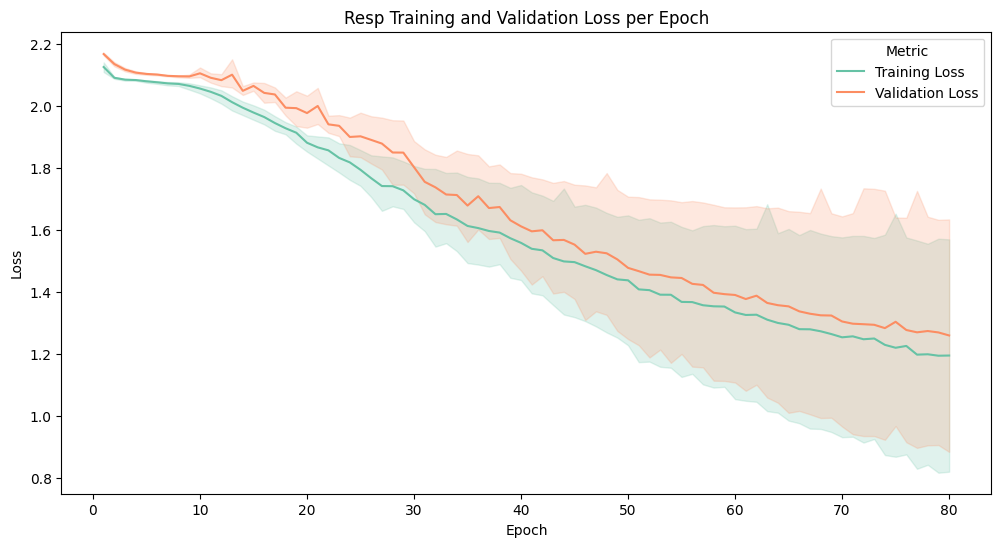

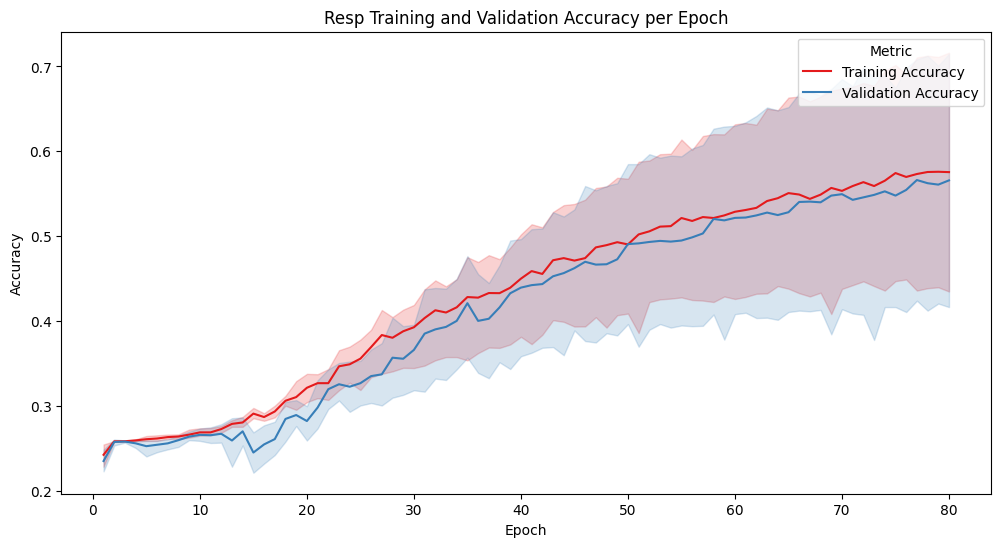

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

First 120 predicted labels for the test data:
[ 1  0  2  1  2  1  2  2  2  1  1 -1  2  2  0  1  0  0  1  2  0  0  1  1
  2  0  1  1  2  2 -4  1 -3  1  1 -4 -4  1  2  1 -4 -4  2 -4  2  2  0  2
 -4 -4  0 -1  1  1 -3  0  2  1 -3 -4  2  0  2  0  1  1  0  1  0  2  1  2
  0  0  0 -4  0  1  0  0  0 -4  0  0  0 -4  0  0  0  0  2  1  2  1  1  2
  0  1  0  2 -4  1  1 -4  1 -2  2  1  2  1 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4]


In [5]:
# Shift labels from range -4 to 4 to 0 to 8
train_data['labels'] = train_data['labels'] + 4

# Convert to categorical (one-hot encoding)
num_classes = 9  # Since labels range from 0 to 8 after shifting
y_train_categorical = to_categorical(train_data['labels'], num_classes=num_classes)

# Shuffle data
X_train, y_train_categorical = shuffle(train_data['resp_data'], y_train_categorical, random_state=42)
X_test = test_data['resp_data']

# Normalize data using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Flatten data for PCA
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_flat = imputer.fit_transform(X_train_flat)
X_test_flat = imputer.transform(X_test_flat)

# Apply PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# Reshape data for input into Conv1D (add channel dimension)
X_train_pca = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1], 1))
X_test_pca = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1))

# Define the CNN-LSTM model for classification
def create_cnn_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.1)(x)
    x = Conv1D(64, kernel_size=3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = LSTM(64, return_sequences=False)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Initialize StratifiedKFold cross-validation
skf = StratifiedKFold(n_splits=4)

fold_no = 1
accuracy_per_fold = []
loss_per_fold = []
train_accuracy_per_fold = []
train_loss_per_fold = []

# Create a list to store epoch-wise data
epoch_data = []

# Perform Stratified K-fold cross-validation
y_labels_train = np.argmax(y_train_categorical, axis=1)  # Convert to 1D array for stratification
for train_index, val_index in skf.split(X_train_pca, y_labels_train):
    print(f'Training on fold {fold_no}...')

    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_pca[train_index], X_train_pca[val_index]
    y_train_fold, y_val_fold = y_train_categorical[train_index], y_train_categorical[val_index]

    # Create and compile the model
    model = create_cnn_lstm_model(input_shape=(X_train_pca.shape[1], 1), num_classes=num_classes)
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Early stopping and learning rate reduction callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    # Train the model with early stopping and learning rate reduction
    history = model.fit(X_train_fold, y_train_fold,
                        epochs=80,
                        batch_size=64,
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=[early_stopping, reduce_lr],
                        verbose=1)

    # Evaluate the model on the validation set for this fold
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    train_loss, train_accuracy = model.evaluate(X_train_fold, y_train_fold, verbose=0)

    print(f'Fold {fold_no} - Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    print(f'Fold {fold_no} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Store training and validation metrics for this fold
    accuracy_per_fold.append(val_accuracy)
    loss_per_fold.append(val_loss)
    train_accuracy_per_fold.append(train_accuracy)
    train_loss_per_fold.append(train_loss)

    # Gather epoch-wise data for plotting
    for epoch in range(len(history.history['loss'])):
        epoch_data.append({
            'Epoch': epoch + 1,
            'Training Loss': history.history['loss'][epoch],
            'Validation Loss': history.history['val_loss'][epoch],
            'Training Accuracy': history.history['accuracy'][epoch],
            'Validation Accuracy': history.history['val_accuracy'][epoch],
            'Fold': fold_no
        })

    fold_no += 1

# Print cross-validation results
print('\nCross-validation results:')
print(f'Average Training Accuracy: {np.mean(train_accuracy_per_fold):.4f} ± {np.std(train_accuracy_per_fold):.4f}')
print(f'Average Training Loss: {np.mean(train_loss_per_fold):.4f} ± {np.std(train_loss_per_fold):.4f}')
print(f'Average Validation Accuracy: {np.mean(accuracy_per_fold):.4f} ± {np.std(accuracy_per_fold):.4f}')
print(f'Average Validation Loss: {np.mean(loss_per_fold):.4f} ± {np.std(loss_per_fold):.4f}')

# Convert epoch data to DataFrame
df_epochs = pd.DataFrame(epoch_data)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
sns.lineplot(x='Epoch', y='value', hue='variable',
             data=pd.melt(df_epochs, ['Epoch', 'Fold'], value_vars=['Training Loss', 'Validation Loss']),
             palette='Set2')
plt.title('Resp Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Metric')
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
sns.lineplot(x='Epoch', y='value', hue='variable',
             data=pd.melt(df_epochs, ['Epoch', 'Fold'], value_vars=['Training Accuracy', 'Validation Accuracy']),
             palette='Set1')
plt.title('Resp Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Metric')
plt.show()

# Making predictions on the test data using the final model (trained on the last fold)
predictions_prob = model.predict(X_test_pca)
predictions_class = np.argmax(predictions_prob, axis=1)

# Reverse the shift to get labels in the original range of -4 to 4
predicted_labels = predictions_class - 4

# Print the first 120 predicted labels
print("\nFirst 120 predicted labels for the test data:")
print(predicted_labels[:120])
